In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [15, 5]

In [2]:
%load_ext autoreload
%autoreload 2
%run '../main.py'

In [4]:
dataSetOps = DataSetOps()

dataSetOps.import_years(2017, 2017)

dataSetOps.prepare()


df = dataSetOps.df

dataSetOps2 = DataSetOps()

dataSetOps2.import_years(2018, 2018)

dataSetOps2.prepare()


df2 = dataSetOps2.df

In [5]:
# variables
mavgl = 30
window = 20
epilson = 0.0001
ew = 3

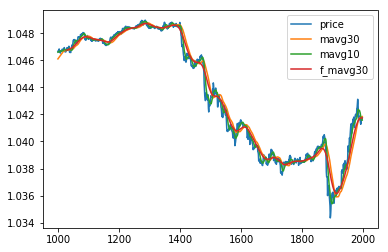

In [6]:
mavgl = str(mavgl)
df['f_mavg' + mavgl] = df['mavg' + mavgl].shift(-window).rolling(window=30).mean()
df['f_price_max'] = df['price'].shift(-window).rolling(window=window).max()
df['f_price_min'] = df['price'].shift(-window).rolling(window=window).min()
df['value'] = df['f_mavg' + mavgl] - df['mavg' + mavgl] > epilson
df['value_real_1'] = df['f_price_max'] - df['price'] > epilson * ew
df['value_real_2'] = df['price'] - df['f_price_min'] < epilson * ew
df['value'] = df['value_real_1'] & df['value_real_2']
df[['price', 'mavg' + mavgl, 'mavg10', 'f_mavg' + mavgl]].head(1000).plot()

0.3234799735588922


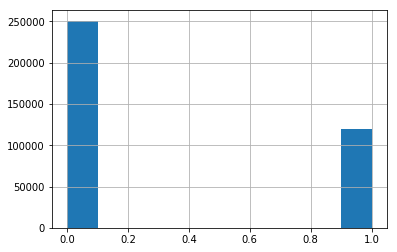

In [7]:
df['value'].astype(int).hist()
print(len(df[df['value']]) / (len(df)))

In [8]:
X = df[['price', 'mavg10', 'mavg20', 'mavg50', 'mavg80', 'mavg100', 'mavg1000']]
Y = df['value']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

    
#Initializing Neural Network
classifier = Sequential()

class1 = Dense(output_dim = 16, init = 'uniform', activation = 'relu', input_dim = 7)
class2 = Dense(output_dim = 16, init = 'uniform', activation = 'relu')
class3 = Dense(output_dim = 16, init = 'uniform', activation = 'relu')
# Adding the input layer and the first hidden layer
classifier.add(class1)
# Adding the second hidden layer
classifier.add(class2)
classifier.add(class3)
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling Neural Network
from keras import metrics
metric_names = [metrics.mae, 'accuracy']
classifier.compile(optimizer='adam', loss = 'mean_squared_error', metrics=metric_names)


# Fitting our model 
classifier.fit(X_train, y_train, batch_size = 20, epochs = 2)
import random
classifier.save("/tmp/mavg_classifier_" + str(random.randint(100000, 999999)))

Using TensorFlow backend.
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=7, units=16, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  if sys.path[0] == '':
/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


Epoch 1/2
333571/333571 [==============================] - 7s 21us/step - loss: 0.2192 - mean_absolute_error: 0.4383 - acc: 0.6766
Epoch 2/2
333571/333571 [==============================] - 7s 21us/step - loss: 0.2189 - mean_absolute_error: 0.4378 - acc: 0.6766


In [10]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
from lib.helper import AccuracyCalculator

# Predicting the Test set results
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, (y_pred > 0.8))

AccuracyCalculator.class_accuracy(cm)
AccuracyCalculator.optimistic_accuracy(y_pred[:,0], y_test, 100)
risk_hist_df = AccuracyCalculator.risk_hist(y_pred[:,0], y_test)


class_accuracy => accuracy:  0.5 risk:  1
optimistic_accuracy => risk:  0.67 min pass point:  0.32449865


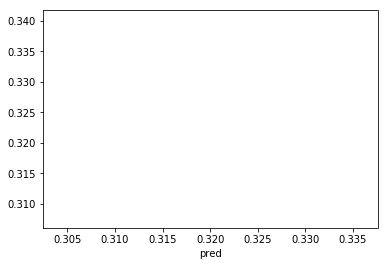

In [11]:
(1-risk_hist_df.risk).plot()

In [12]:
cm

array([[25059,     0],
       [12005,     0]])

In [14]:
dfx = df[df['value']]
p_f = len(dfx[dfx['value']]) / len(dfx)
p_r = cm[1,1] / (cm[1,1] + cm[0,1])
print('real prob', p_f , p_r, p_f * p_r)

real prob 1.0 nan nan


/home/taleh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
y_all_pred = classifier.predict(sc.transform(X))
y_f_price_real = df['value_real']
cm = confusion_matrix(y_f_price_real, (y_all_pred > 0.8))

AccuracyCalculator.class_accuracy(cm)
AccuracyCalculator.optimistic_accuracy(y_all_pred[:,0], y_f_price_real, 100)
risk_hist_df = AccuracyCalculator.risk_hist(y_all_pred[:,0], y_f_price_real)

print(cm)

(1-risk_hist_df.risk).plot()



In [ ]:
dfr = df[df['value']]
dfr['value_real'].astype(int).hist()
print(len(dfr[dfr['value_real']]) / (len(dfr)))
print(len(dfr['value_real']))

In [ ]:
mavgl = str(mavgl)
df2['f_price'] = df2['price'].shift(-window).rolling(window=window).max()
df2['value_real'] = df2['f_price'] - df2['price'] > epilson * ew

X2 = df2[['price', 'mavg10', 'mavg20', 'mavg50', 'mavg80', 'mavg100', 'mavg1000']]

y_all_pred2 = classifier.predict(sc.transform(X2))
y_f_price_real2 = df2['value_real']
cm2 = confusion_matrix(y_f_price_real2, (y_all_pred2 > 0.8))

AccuracyCalculator.class_accuracy(cm2)
AccuracyCalculator.optimistic_accuracy(y_all_pred2[:,0], y_f_price_real2, 100)
risk_hist_df2 = AccuracyCalculator.risk_hist(y_all_pred2[:,0], y_f_price_real2)

print(cm2)

(1-risk_hist_df2.risk).plot()



In [ ]:

classifier.fit(X_train, y_train, batch_size = 2, epochs = 60 * 8)

In [ ]:

import random
classifier.save("/tmp/mavg_classifier_" + str(random.randint(100000, 999999)))